### Exercise 17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

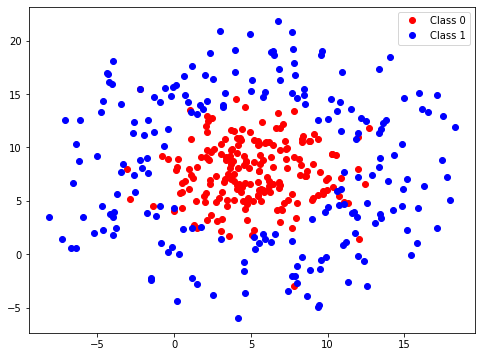

In [2]:
# Synthetic data
m_= 200
mu = np.array([5,8])
sigma = np.array([[10,0],[0,10]])
X1 = np.random.multivariate_normal(mu,sigma,m_)

phi = np.random.uniform(0,2*np.pi,m_).reshape(-1,1)
r = 6 + np.random.uniform(0,8,m_).reshape(-1,1)
X2 = np.concatenate((r*np.cos(phi)+mu[0],r*np.sin(phi)+mu[1]),1)

plt.figure(figsize=(8,6))
plt.plot(X1[:,0],X1[:,1],'ro',label = 'Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label = 'Class 1')
plt.legend()
plt.show()

#### SVM prediction using Kernel with Slack variables
- Traing data:$X \in R^{n}, y = \{-1,1\}$
$$
2D: \mathbf{X} = \begin{vmatrix}x_{1}^{1} & x_{2}^{1} \\x_{1}^{2} & x_{2}^{2}\\: & :\\x_{1}^{m} & x_{2}^{m}\end{vmatrix} , \mathbf{y} = \begin{vmatrix} -1\\-1\\:\\1\end{vmatrix}
$$

In [3]:
# Training data
X = np.concatenate((X1,X2),0)
y = np.concatenate((-np.ones((m_,1)),np.ones((m_,1))),0)
m = X.shape[0]
n = np.unique(y).shape[0]

**Kernel:**

$$\small \text{Linear Kernel: $\mathcal k(x,x^{'}) = x_{1}x_{1}^{'}+x_{2}x_{2}^{'}+...+x_{n}x_{n}^{'}$} $$
$$\small \text{Polynomial Kernel: $\mathcal k(x,x^{'}) = x_{1}^{2}x_{1}^{'2}+x_{2}^{2}x_{2}^{'2}+...+x_{n}^{2}x_{n}^{'2}$} $$
$$\small \text{RBF Kernel (Radial Basis Function): $\mathcal k(x,x^{'}) = \mathrm{e}^{\frac{-||x-x^{'}||^{2}}{2\sigma^{2}}} \\ 
K = \underbrace{\begin{vmatrix}K(x^{1},x^{1}) & K(x^{1},x^{2}) & .. & K(x^{1},x^{m}) \\K(x^{2},x^{1}) & K(x^{2},x^{2}) & .. & K(x^{2},x^{m})\\: & :& :\\K(x^{m},x^{1}) & K(x^{m},x^{2}) & .. & K(x^{m},x^{m})\end{vmatrix}}_{m \times m} $}$$

In [17]:
# RBF kernel
def rbf_kernel(X,rbf_sigma):
    m = X.shape[0]
    K = np.zeros((m,m))
    for i in range (m):
        for j in range (m):
            K[i,j] = (X[i,:]-X[j,:])@(X[i,:]-X[j,:])
    K = np.exp(-K/(2*rbf_sigma**2))
    return K

**General Quadratic Programming**
$$x^{*} = arg \min_{x}\frac{1}{2}x^{T}Qx+c^{T}x+r $$ $$\text{Subject to : $Ax \leq b\\ Ex = d$}$$
- **cvxopt**.solvers.qp(P,q,G,h,A,b) find the **sol['x']**

**Dual Lagrangian Optimization with Slack variable:**
$$ \mathcal W(\alpha) = \min_{\alpha} \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_{i}\alpha_{j}y^{(i)}y^{(j)}\mathcal k(x,x^{'}) - \sum_{i=1}^{m}\alpha_{i} $$
$$\text{Such that: $0 \le \alpha_{i} \le C, i \in 1...m \\ \sum_{i=1}^{m}\alpha_{i}y^{(i)} = 0 $}$$

$$
Q=y^{(i)}y^{(j)}\mathcal k(x,x^{'}) ; 
c = \underbrace{\begin{vmatrix} -1\\-1\\:\\-1\end{vmatrix}}_{m \times 1} ; 
A = \underbrace{\begin{vmatrix}-1 & 0 & .. & 0 \\0 & -1 & .. & 0\\: & :& :\\0 & 0 & .. & -1\\1 & 0 & .. & 0 \\0 & 1 & .. & 0\\: & :& :\\0 & 0 & .. & 1\end{vmatrix}}_{2m \times m} ; 
b =\underbrace{\begin{vmatrix}0\\0 \\:\\0\\C\\C \\:\\C\end{vmatrix}}_{2m \times 1} ; 
E = \underbrace{\begin{vmatrix}y_{1} & y_{2} & .. & y_{m}\end{vmatrix}}_{1 \times m} ; d = 0
$$

In [22]:
# Set Q,c,A,b,E,d
rbf_sigma = 1
C = 2
Q = y@y.T*rbf_kernel(X,rbf_sigma)
c = -np.ones((m,1))
A = np.concatenate((-np.eye((m)),np.eye((m))),0)
b = np.concatenate((np.zeros((m,1)),np.ones((m,1))*C),0)
E = y.T
d = np.zeros((1,1))

In [8]:
# cvxopt_solvers_qp function
def cvxopt_solvers_qp(Q,c,A=None,b=None,E=None,d=None):
    Q = .5*(Q+Q.T) # make Q is symmetric
    args = [cvxopt.matrix(Q),cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A),cvxopt.matrix(b)])
    if E is not None:
        args.extend([cvxopt.matrix(E),cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    return np.array(sol['x']).reshape((Q.shape[1]))
opt_params = cvxopt_solvers_qp(Q,c,A,b,E,d)

     pcost       dcost       gap    pres   dres
 0: -8.1769e+01 -1.5620e+03  4e+03  9e-01  1e-15
 1: -7.0809e+01 -5.3140e+02  5e+02  8e-15  6e-16
 2: -1.1889e+02 -2.0500e+02  9e+01  1e-14  7e-16
 3: -1.3102e+02 -1.4827e+02  2e+01  4e-15  5e-16
 4: -1.3334e+02 -1.3656e+02  3e+00  1e-16  4e-16
 5: -1.3389e+02 -1.3459e+02  7e-01  6e-15  4e-16
 6: -1.3402e+02 -1.3422e+02  2e-01  1e-14  4e-16
 7: -1.3405e+02 -1.3410e+02  5e-02  3e-14  4e-16
 8: -1.3405e+02 -1.3408e+02  2e-02  1e-14  4e-16
 9: -1.3406e+02 -1.3406e+02  4e-03  2e-14  4e-16
10: -1.3406e+02 -1.3406e+02  4e-04  1e-14  4e-16
11: -1.3406e+02 -1.3406e+02  2e-05  4e-14  4e-16
Optimal solution found.


**Find b**:

$\mathcal S \small \text{ is the set of indexes of the support vectors: } \mathcal S = \{ i \in 1..m | \alpha_{i} > 0 \}; N_{\mathcal S} = len(\mathcal S)$

$$b =\frac{1}{N_{\mathcal S}}\sum_{i \in \mathcal S} \left(y^{(i)} - \sum_{j \in \mathcal S}\alpha_{j}y^{(j)} \mathcal k(x,x^{'}) \right)$$

In [ ]:
# Finb b from otp_params function
def find_b(X,y,alpha,rbf_sigma):
    S = np.where(alpha[alpha>1e-5])[0] #[0] make S as numpy array
    X_s = X[S,:]
    y_s = y[S]
    alphas = alpha[S].reshape(-1,1)
    b = (y_s - ((alphas*y_s).T*rbf_kernel(X_s,rbf_sigma)).sum(axis=1,keepdims=True)).mean()
    return b